In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import torch.nn as nn
import torch.optim as optim

In [2]:
labelsRGB= []
with open("C:/Users/ASUS/Desktop/New folder/A1/Q3/CamVid/class_dict.csv", mode="r") as csvFile:
    reader = csv.reader(csvFile)  # Create a CSV reader
    for row in reader:
        labelsRGB.append(row)
for i in labelsRGB:
  for j in range(len(i)):
    i[j] = i[j].strip()
#print(labelsRGB)

dictLabelsValues = {}

for i in range(1, len(labelsRGB)):
    dictLabelsValues[tuple(labelsRGB[i][1:])] = i-1

print(dictLabelsValues)

{('64', '128', '64'): 0, ('192', '0', '128'): 1, ('0', '128', '192'): 2, ('0', '128', '64'): 3, ('128', '0', '0'): 4, ('64', '0', '128'): 5, ('64', '0', '192'): 6, ('192', '128', '64'): 7, ('192', '192', '128'): 8, ('64', '64', '128'): 9, ('128', '0', '192'): 10, ('192', '0', '64'): 11, ('128', '128', '64'): 12, ('192', '0', '192'): 13, ('128', '64', '64'): 14, ('64', '192', '128'): 15, ('64', '64', '0'): 16, ('128', '64', '128'): 17, ('128', '128', '192'): 18, ('0', '0', '192'): 19, ('192', '128', '128'): 20, ('128', '128', '128'): 21, ('64', '128', '192'): 22, ('0', '0', '64'): 23, ('0', '64', '64'): 24, ('192', '64', '128'): 25, ('128', '128', '0'): 26, ('192', '128', '192'): 27, ('64', '0', '64'): 28, ('192', '192', '0'): 29, ('0', '0', '0'): 30, ('64', '192', '0'): 31}


In [3]:
pathToTrain = "C:/Users/ASUS/Desktop/New folder/A1/Q3/CamVid/train"
pathToTrainLabels = "C:/Users/ASUS/Desktop/New folder/A1/Q3/CamVid/train_labels"
pathToTestImages = "C:/Users/ASUS/Desktop/New folder/A1/Q3/CamVid/test_images"
pathToTestLabels = "C:/Users/ASUS/Desktop/New folder/A1/Q3/CamVid/test_labels"
folderPath = "C:/Users/ASUS/Desktop/New folder/A1/Q3/A3_CSV_SEGMENTED"

In [4]:
class dataset(Dataset):
  transformReqByQuestion = transforms.Compose([
    transforms.Resize((360, 480)),  # Resizing the image
    transforms.ToTensor(),  # Convert to torch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing it
    ])
  

  resizeTransform = transforms.Compose([
    transforms.Resize((360, 480))  # Resizing the image
,transforms.ToTensor()])
    
  dictLabelsValues ={('64', '128', '64'): 0, ('192', '0', '128'): 1, ('0', '128', '192'): 2, ('0', '128', '64'): 3, ('128', '0', '0'): 4, ('64', '0', '128'): 5, ('64', '0', '192'): 6, ('192', '128', '64'): 7, ('192', '192', '128'): 8, ('64', '64', '128'): 9, ('128', '0', '192'): 10, ('192', '0', '64'): 11, ('128', '128', '64'): 12, ('192', '0', '192'): 13, ('128', '64', '64'): 14, ('64', '192', '128'): 15, ('64', '64', '0'): 16, ('128', '64', '128'): 17, ('128', '128', '192'): 18, ('0', '0', '192'): 19, ('192', '128', '128'): 20, ('128', '128', '128'): 21, ('64', '128', '192'): 22, ('0', '0', '64'): 23, ('0', '64', '64'): 24, ('192', '64', '128'): 25, ('128', '128', '0'): 26, ('192', '128', '192'): 27, ('64', '0', '64'): 28, ('192', '192', '0'): 29, ('0', '0', '0'): 30, ('64', '192', '0'): 31}
     
  def __init__(self,images_path, labels_path):
    self.images_path = images_path
    self.labels_path = labels_path
    self.images_list = os.listdir(images_path)#name of all images
    self.labels_list = os.listdir(labels_path)#name of all masks
    self.images_list.sort()
    self.labels_list.sort()
  def __len__(self):
    return len(self.images_list)
  def _labelAssigningFunction(self, label):
    label_np = label.numpy().astype(int)#label tensor to label numpy; faster indexing
    # Reshaping label to (H*W, 3) for efficient lookup
    h, w = label_np.shape[1], label_np.shape[2]
    label_reshaped = label_np.reshape(3, -1).T  # Shape (H*W, 3)
    # Convert RGB values to string format (keys for dict lookup)
    label_strings = [tuple(map(str, rgb)) for rgb in label_reshaped]
    # Use NumPy's vectorized lookup for fast dictionary mapping
    labelAssigned = np.array([dataset.dictLabelsValues.get(rgb, 30) for rgb in label_strings])
    # Reshape back to (H, W) and convert to PyTorch tensor
    mask_Image = torch.tensor(labelAssigned.reshape(h, w))
    return mask_Image
      
  def __getitem__(self,index):
    image_name = self.images_list[index]
    image_path = os.path.join(self.images_path,image_name)
    #print(image_name)
    #print(image_path)
    label_name = self.labels_list[index]
    label_path = os.path.join(self.labels_path,label_name)
    #print(label_name)
    #print(label_path)
    image = Image.open(image_path)
    image_tensor = dataset.transformReqByQuestion(image.convert("RGB"))
    #image_tensor = (image_tensor*255).round().to(torch.uint8)
    #image_array = np.array(image_tensor, dtype=np.uint8)  # Convert to NumPy array (int)
    #print(image_tensor)
    label = Image.open(label_path)
    label_tensor = dataset.resizeTransform(label.convert("RGB"))
    label_tensor = (label_tensor*255).round().to(torch.uint8)

    #label_array = np.array(label_tensor, dtype=np.uint8)  # Convert to NumPy array (int)
    #print(label_tensor)
    mask_Image = self._labelAssigningFunction(label_tensor)
    return image_tensor, label_tensor, mask_Image, image_name, label_name#, image_array, label_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.622571].


0001TP_009210.png
0001TP_009210_L.png


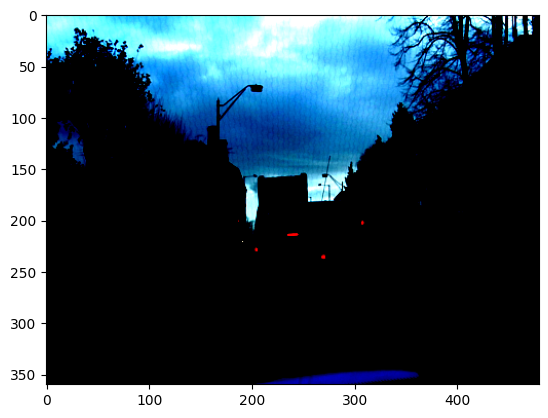

In [5]:
CamVidDataset = dataset(pathToTrain,pathToTrainLabels)
image,label,mask,image_name,label_name = CamVidDataset[0]
print(image_name)
print(label_name)
plt.imshow(image.permute(1,2,0))
#plt.imshow(label.permute(1,2,0))
#print(label)
#_,_,k,_,_ = CamVidDataset[len(CamVidDataset)-1]
#print(k.dtype)
#print(k.shape)

# plt.imshow(label.permute(1,2,0))

# trainDataLoader = DataLoader(dataset=CamVidDataset, batch_size=32, shuffle=True)
trainDataLoader = DataLoader(dataset=CamVidDataset, batch_size=3, shuffle=True, num_workers=0)
# image,label,image_name,label_name = next(iter(dataLoader))
# print(image_name)
# plt.imshow(image[0].permute(1,2,0))

In [ ]:
# labelAssigningVector = torch.zeros(len(CamVidDataset), 360, 480, dtype=torch.uint8)
# for i in range(len(CamVidDataset)):
#     image, label, image_name, label_name = CamVidDataset[i]  # Getting the data sample
#     for j in range(360):
#         for k in range(480):
#             r = str(int(label[0, j, k]))
#             g = str(int(label[1, j, k]))
#             b = str(int(label[2, j, k]))
#             labelAssigned = dictLabelsValues.get((r, g, b),30)

#             labelAssigningVector[i, j, k] = labelAssigned

# print(labelAssigningVector)

tensor([[[22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         ...,
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31]],

        [[22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         ...,
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31]],

        [[22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         [22, 22, 22,  ..., 27, 27, 27],
         ...,
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31],
         [20, 20, 20,  ..., 31, 31, 31]],

        ...,

        [[ 5,  5,  5,  ..., 27, 27, 27],
         [ 5,  5,  5,  ..., 27, 27, 27],
         [ 5,  5,  5,  ..., 27, 27, 27],
         ...,
         [20, 20, 20,  ..., 18, 18, 18],
         [20, 20, 20, 

In [6]:
# # Save each channel separately
# for i in range(labelAssigningVector.shape[0]):
#   _,_,_,label_name = CamVidDataset[i]
#   df = pd.DataFrame(labelAssigningVector[i].numpy())  # Convert each 2D slice to DataFrame
#   file_name = f"segmented_Image_{label_name[:-4]}.csv"
#   file_path = os.path.join(folderPath, file_name)
#   df.to_csv(file_path, index=False, header=False)
_,_,k,_,_ = CamVidDataset[0]
print(k)
# print("Saved CSV files for each channel!")

tensor([[21., 21., 21.,  ..., 26., 26., 26.],
        [21., 21., 21.,  ..., 26., 26., 26.],
        [21., 21., 21.,  ..., 26., 26., 26.],
        ...,
        [19., 19., 19.,  ..., 30., 30., 30.],
        [19., 19., 19.,  ..., 30., 30., 30.],
        [19., 19., 19.,  ..., 30., 30., 30.]])


In [ ]:
# #Code For Deletion
# for i in range(labelAssigningVector.shape[0]):
#   _,_,_,label_name = CamVidDataset[i]
#   file_name = f"tensor_channel_{label_name}.csv" if isinstance(label_name, list) else f"segmented_Image_{label_name}.csv"
#   file_path = os.path.join(folderPath,file_name)
#   if os.path.exists(file_path):  # Check if the file exists
#       os.remove(file_path)  # Delete the file
#       print(f"Deleted: {file_name}")
#   else:
#       print(f"File not found: {file_name}")


In [6]:
CamVidTestDataset = dataset(pathToTestImages,pathToTestLabels)
# testDataLoader = DataLoader(dataset=CamVidTestDataset, batch_size=32, shuffle=True)
testDataLoader = DataLoader(dataset=CamVidTestDataset, batch_size=16, shuffle=True)
# labelAssigningVector1 = torch.zeros(len(CamVidTestDataset), 360, 480, dtype=torch.uint8)
# for i in range(len(CamVidTestDataset)):
#     image, label, image_name, label_name = CamVidTestDataset[i]  # Getting the data sample
#     for j in range(360):
#         for k in range(480):
#             r = str(int(label[0, j, k]))
#             g = str(int(label[1, j, k]))
#             b = str(int(label[2, j, k]))
#             labelAssigned = dictLabelsValues.get((r, g, b),31)

#             labelAssigningVector1[i, j, k] = labelAssigned
# Save each channel separately

In [8]:
# for i in range(labelAssigningVector1.shape[0]):
#   _,_,_,label_name = CamVidTestDataset[i]
#   df = pd.DataFrame(labelAssigningVector1[i].numpy())  # Convert each 2D slice to DataFrame
#   file_name = f"test_segmented_Image_{label_name[:-4]}.csv"
#   file_path = os.path.join(folderPath, file_name)
#   df.to_csv(file_path, index=False, header=False)


# print("Saved CSV files for each channel!")

Saved CSV files for each channel!


In [59]:
type(trainDataLoader)

torch.utils.data.dataloader.DataLoader

In [7]:
# dictValuesVisualisation = {}
# for i in range(0,32):
#   dictValuesVisualisation[i] = 0
# for i in range(0,16):
#   dictValuesVisualisation[i] = 0
# csv_files = [file for file in os.listdir(folderPath) if file.endswith(".csv")]

# for file in csv_files:
#     file_path = os.path.join(folderPath, file)
#     df = pd.read_csv(file_path,header=None)
#     for i in  range(360):
#       for j in range(480):
#         dictValuesVisualisation[df.iloc[i,j]-1]+=1
# print(dictValuesVisualisation)
# for batch in trainDataLoader:
#     masks_batch  = batch[2]
#     for mask_idx_in_batch in range(masks_batch.shape[0]):  # For each image in the batch
#         mask = masks_batch[mask_idx_in_batch]
#         for j in range(360):
#             for k in range(480):
#                 dictValuesVisualisation[int(mask[i,j])]+=1
# print(dictValuesVisualisation)
dictValuesVisualisation = {i: 0 for i in range(32)}  # Initialize dictionary

for batch in trainDataLoader:
    masks_batch = batch[2]  # Get masks from batch (Shape: B x 360 x 480)

    # Flatten the entire batch to a 1D array
    masks_flat = masks_batch.view(-1)  # Shape: (B * 360 * 480,)

    # Use torch.bincount to count occurrences of each label (up to 32)
    counts = torch.bincount(masks_flat, minlength=32).tolist()

    # Update dictionary with counts
    dictValuesVisualisation = {i: dictValuesVisualisation[i] + counts[i] for i in range(32)}

print(dictValuesVisualisation)

{0: 3040, 1: 23027, 2: 254332, 3: 25280, 4: 13876111, 5: 1854691, 6: 10711, 7: 12471, 8: 261965, 9: 968013, 10: 587176, 11: 2646, 12: 375200, 13: 2821, 14: 256268, 15: 195708, 16: 281318, 17: 17239218, 18: 132940, 19: 4028135, 20: 61555, 21: 8690440, 22: 313535, 23: 1266, 24: 182074, 25: 4, 26: 5888337, 27: 107299, 28: 5, 29: 460700, 30: 6982304, 31: 684610}


In [8]:
for batch in testDataLoader:
    masks_batch = batch[2]  # Get masks from batch (Shape: B x 360 x 480)
    # Flatten the entire batch to a 1D array
    masks_flat = masks_batch.view(-1)  # Shape: (B * 360 * 480,)
    # Use torch.bincount to count occurrences of each label (up to 32)
    counts = torch.bincount(masks_flat, minlength=32).tolist()
    # Update dictionary with counts
    dictValuesVisualisation = {i: dictValuesVisualisation[i] + counts[i] for i in range(32)}
print(dictValuesVisualisation)

{0: 5137, 1: 30067, 2: 468170, 3: 46299, 4: 22624189, 5: 3275168, 6: 19054, 7: 19136, 8: 392357, 9: 1370184, 10: 835386, 11: 2908, 12: 539236, 13: 9495, 14: 364171, 15: 312826, 16: 476184, 17: 26554715, 18: 206938, 19: 6143345, 20: 93698, 21: 14995507, 22: 667334, 23: 1345, 24: 298000, 25: 4, 26: 9948999, 27: 547549, 28: 9, 29: 670218, 30: 11678946, 31: 1256226}


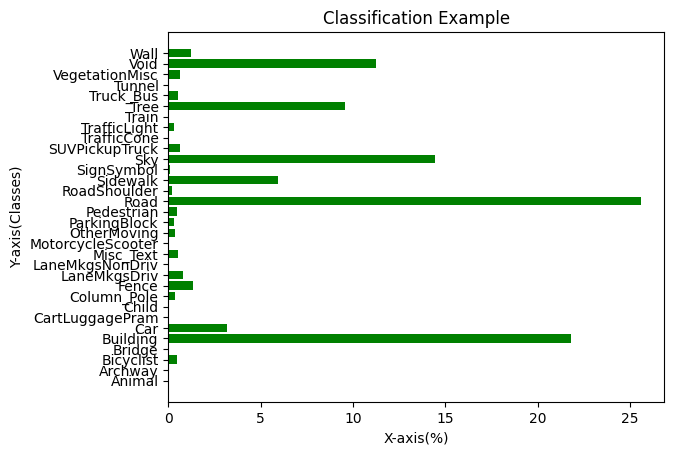

In [9]:
#{1: 5137, 2: 30067, 3: 468170, 4: 46299, 5: 22624189, 6: 3275168, 7: 19054, 8: 19136, 9: 392357, 10: 1370184, 11: 835386, 12: 2908, 13: 539236, 14: 9495, 15: 364171, 16: 312826, 17: 476184, 18: 26554715, 19: 206938, 20: 6143345, 21: 93698, 22: 14995507, 23: 667334, 24: 1345, 25: 298000, 26: 4, 27: 9948999, 28: 547549, 29: 9, 30: 670218, 31: 11678946, 32: 1256226}
x_classification = []
for i in labelsRGB:
  if i[0]=='name':
    continue
  x_classification.append(i[0])
y = []
sum = 0
for i in dictValuesVisualisation.keys():
  sum+=dictValuesVisualisation[i]
  y.append(dictValuesVisualisation[i])
for i in range(len(y)):
  y[i] = y[i]/sum*100
plt.barh(x_classification, y, color='green')
plt.xlabel("X-axis(%)")
plt.ylabel("Y-axis(Classes)")
plt.title("Classification Example")
plt.show()

In [13]:
print(dictValuesVisualisation)

{1: 5137, 2: 30067, 3: 468170, 4: 46299, 5: 22624189, 6: 3275168, 7: 19054, 8: 19136, 9: 392357, 10: 1370184, 11: 835386, 12: 2908, 13: 539236, 14: 9495, 15: 364171, 16: 312826, 17: 476184, 18: 26554715, 19: 206938, 20: 6143345, 21: 93698, 22: 14995507, 23: 667334, 24: 1345, 25: 298000, 26: 4, 27: 9948999, 28: 547549, 29: 9, 30: 670218, 31: 11678946, 32: 1256226}


In [46]:
def check_got(listTensor):
    for i in listTensor:
        if(len(i)<2):
            return False
    return True

In [47]:
#{1: 5137, 2: 30067, 3: 468170, 4: 46299, 5: 22624189, 6: 3275168, 7: 19054, 8: 19136, 9: 392357, 10: 1370184, 11: 835386, 12: 2908, 13: 539236, 14: 9495, 15: 364171, 16: 312826, 17: 476184, 18: 26554715, 19: 206938, 20: 6143345, 21: 93698, 22: 14995507, 23: 667334, 24: 1345, 25: 298000, 26: 4, 27: 9948999, 28: 547549, 29: 9, 30: 670218, 31: 11678946, 32: 1256226}

#dictMaintainNumberImagesIdentified = {}
listTensor = []  # Creating 32 empty lists (for pixel values 0 to 31)

# Initialize dictionary
for i in range(0, 32):
    #dictMaintainNumberImagesIdentified[i] = 0 
    listTensor.append([])

for i in range(len(CamVidDataset)):
    image_tensor,label_tensor,mask,_,_ = CamVidDataset[i]
    NPimage_tensor = image_tensor.numpy()
    NPLabel_tensor = label_tensor.numpy()
    for j in range(360):
        for k in range(480):
            pixelValue = int(mask[j,k])
            # Ensure we store unique images for each pixelValue
            if len(listTensor[pixelValue]) == 0:
                listTensor[pixelValue].append([label_tensor,image_tensor,mask])
            
            elif len(listTensor[pixelValue]) == 1:
                if not torch.equal(listTensor[pixelValue][0][0], label_tensor):
                    listTensor[pixelValue].append([label_tensor,image_tensor,mask])
    
    if check_got(listTensor):  # Ensure check_got function is implemented
        break
# for i in range(len(CamVidDataset)):
#     image_tensor, label_tensor, mask, _, _ = CamVidDataset[i]
#     mask_np = mask.numpy()  # Convert mask to NumPy once

#     # Get unique pixel values in mask
#     unique_pixel_values = np.unique(mask_np)

#     for pixelValue in unique_pixel_values:
#         pixelValue = int(pixelValue)  # Ensure integer
#         stored_list = listTensor[pixelValue]  # Fetch once to avoid repeated indexing

#         # Store the first image-label pair for each pixelValue
#         if len(stored_list) == 0:
#             stored_list.append([label_tensor, image_tensor,mask])
        
#         # Store the second only if it's different from the first
#         elif len(stored_list) == 1 and not torch.equal(stored_list[0][0], label_tensor):
#             stored_list.append([label_tensor, image_tensor,mask])

#     if check_got(listTensor):  # Stop early if all pixel values have 2 examples
#         break



In [39]:
print(len(listTensor))

32


In [7]:
classToRGB = {}
for items, values in dictLabelsValues.items():
    classToRGB[values]=items
print(classToRGB)

{0: ('64', '128', '64'), 1: ('192', '0', '128'), 2: ('0', '128', '192'), 3: ('0', '128', '64'), 4: ('128', '0', '0'), 5: ('64', '0', '128'), 6: ('64', '0', '192'), 7: ('192', '128', '64'), 8: ('192', '192', '128'), 9: ('64', '64', '128'), 10: ('128', '0', '192'), 11: ('192', '0', '64'), 12: ('128', '128', '64'), 13: ('192', '0', '192'), 14: ('128', '64', '64'), 15: ('64', '192', '128'), 16: ('64', '64', '0'), 17: ('128', '64', '128'), 18: ('128', '128', '192'), 19: ('0', '0', '192'), 20: ('192', '128', '128'), 21: ('128', '128', '128'), 22: ('64', '128', '192'), 23: ('0', '0', '64'), 24: ('0', '64', '64'), 25: ('192', '64', '128'), 26: ('128', '128', '0'), 27: ('192', '128', '192'), 28: ('64', '0', '64'), 29: ('192', '192', '0'), 30: ('0', '0', '0'), 31: ('64', '192', '0')}


In [48]:
#{1: ('64', '128', '64'), 2: ('192', '0', '128'), 3: ('0', '128', '192'), 4: ('0', '128', '64'), 5: ('128', '0', '0'), 6: ('64', '0', '128'), 7: ('64', '0', '192'), 8: ('192', '128', '64'), 9: ('192', '192', '128'), 10: ('64', '64', '128'), 11: ('128', '0', '192'), 12: ('192', '0', '64'), 13: ('128', '128', '64'), 14: ('192', '0', '192'), 15: ('128', '64', '64'), 16: ('64', '192', '128'), 17: ('64', '64', '0'), 18: ('128', '64', '128'), 19: ('128', '128', '192'), 20: ('0', '0', '192'), 21: ('192', '128', '128'), 22: ('128', '128', '128'), 23: ('64', '128', '192'), 24: ('0', '0', '64'), 25: ('0', '64', '64'), 26: ('192', '64', '128'), 27: ('128', '128', '0'), 28: ('192', '128', '192'), 29: ('64', '0', '64'), 30: ('192', '192', '0'), 31: ('0', '0', '0'), 32: ('64', '192', '0')}
for i in range(len(listTensor)):
    for n in range(len(listTensor[i])):
        ImagesCollection = listTensor[i][n]
        # print(ImagesCollection[0].shape)
        # print(ImagesCollection[1].shape)
        # print(ImagesCollection[2].shape)
        # print(ImagesCollection[0].shape)
        # print(ImagesCollection[1].shape)
        # print(ImagesCollection[2].shape)
        for h in range(360):
            for w in range(480):     
                if(int(ImagesCollection[2][h,w]) != i):
                    ImagesCollection[0][0,h,w] = 0#classToRGB[i+1][0]
                    ImagesCollection[0][1,h,w] = 0#classToRGB[i+1][1]
                    ImagesCollection[0][2,h,w] = 0#classToRGB[i+1][2]
    

In [12]:
i,j,m,_,_ = CamVidDataset[0]
print(i.shape)
print(j.shape)
print(m.shape)

torch.Size([3, 360, 480])
torch.Size([3, 360, 480])
torch.Size([360, 480])


In [49]:
# Create a blank image (black image of size 360x480)
def create_blank_image(height=360, width=480, channels=3):
    return np.zeros((height, width, channels), dtype=np.uint8)

In [51]:
# for i in range(32):
#     num_pairs = len(listTensor[i])  # Number of available pairs for the class
#     fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 cols

#     for pair_idx in range(2):  # We need 2 pairs (either real or blank)
#         if pair_idx < num_pairs:
#             actual_image = listTensor[i][pair_idx][1]
#             segmented_image = listTensor[i][pair_idx][0]  # Mask image
#         else:
#             actual_image = create_blank_image()  # Create blank original image
#             segmented_image = create_blank_image()  # Create blank mask image

#         row = pair_idx  # 0 for first pair, 1 for second pair

#         # Plot Original Image
#         axes[row, 0].imshow(actual_image.permute(1,2,0))
#         axes[row, 0].set_title(f"Class {i} - Original (Pair {pair_idx+1})")
#         axes[row, 0].axis("off")

#         # Plot Mask Image
#         axes[row, 1].imshow(segmented_image.permute(1,2,0))
#         axes[row, 1].set_title(f"Class {i} - Mask (Pair {pair_idx+1})")
#         axes[row, 1].axis("off")

#     # Adjust spacing
#     plt.tight_layout()
#     plt.show()

def plot_listTensor_images_and_labels(listTensor, classValue):
    """
    Plots both images and their corresponding labels (masks) side by side.

    Args:
        listTensor: List of lists containing (label_tensor, image_tensor) pairs.
        classValue: The specific class index whose images & masks need to be plotted.
    """

    images = listTensor[classValue]  # Get stored images for the given class

    if len(images) == 0:
        print(f"No images stored for class {classValue}.")
        return

    fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))  # Rows = num images, 2 columns (image + mask)

    # Ensure axes is always a 2D list (when 1 image, plt.subplots() returns a 1D array)
    if len(images) == 1:
        axes = axes.reshape(1, 2)  # Reshape axes to always be 2D

    for label_tensor, image_tensor,_ in images:
        image_np = image_tensor.cpu().permute(1,2,0).numpy()  
        label_np = label_tensor.cpu().permute(1,2,0).numpy()  

        # Plot Image
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Class {classValue} - Image {i+1}")
        axes[i, 0].axis("off")

        # Plot Mask/Label
        axes[i, 1].imshow(label_np)  # Use grayscale colormap
        axes[i, 1].set_title(f"Class {classValue} - Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

IndexError: index 25 is out of bounds for axis 0 with size 2

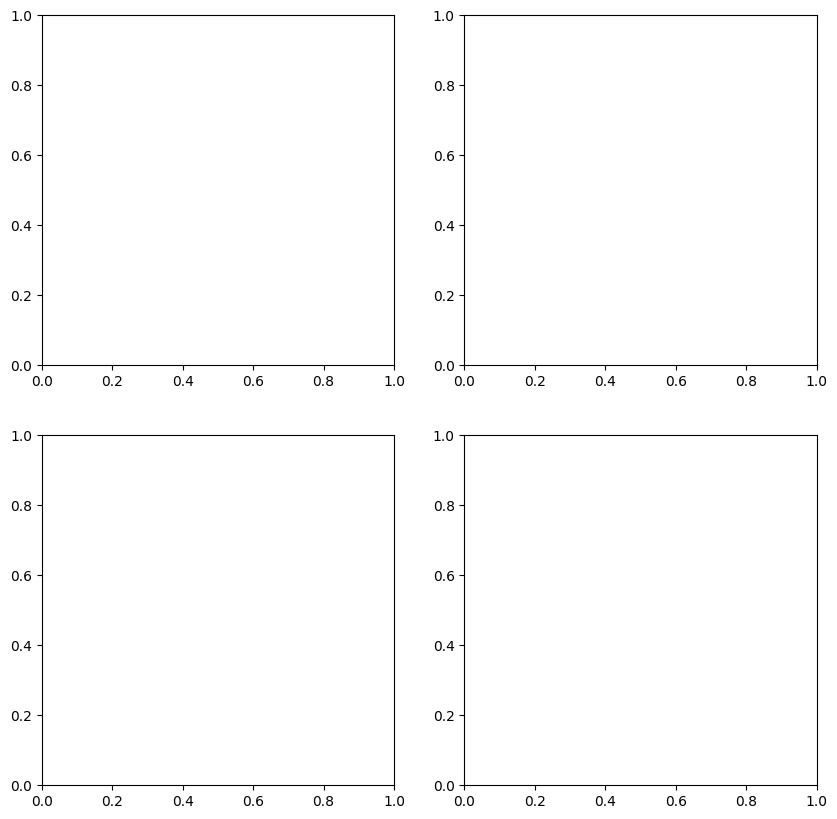

In [55]:
plot_listTensor_images_and_labels(listTensor,1)

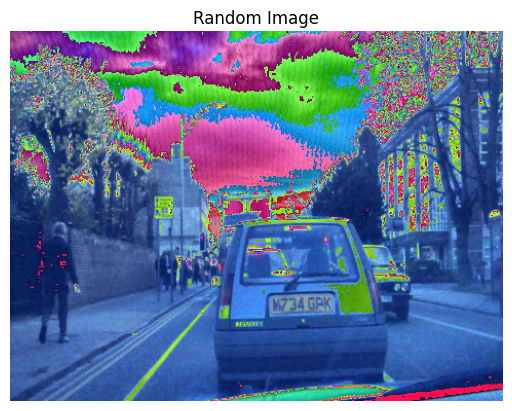

<class 'torch.Tensor'>
torch.Size([3, 360, 480])
torch.uint8


In [47]:
image,_,_,_,_  = CamVidDataset[0]
plt.imshow(image.permute(1,2,0).cpu().numpy())  # Show image
plt.axis("off")  # Hide axes
plt.title("Random Image")
plt.show()
print(type(image))  # Should be numpy.ndarray
print(image.shape)  # Should be (H, W, 3) for RGB
print(image.dtype)  # Should be uint8 (0-255)

In [10]:
print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU

device = "cuda"

import gc
gc.collect()  # Forces garbage collection
torch.cuda.empty_cache()  # Clears CUDA memory

from model_class import SegNet_Pretrained
model = SegNet_Pretrained('C:/Users/ASUS/Desktop/New folder/A1/Q3/encoder_model.pth').to(device)
wandb.init(project = "CamVidDataSet Project")

criterion = nn.CrossEntropyLoss()  # Defining the Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Defining the Adam optimizer
wandb.watch(model)

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


wandb: Currently logged in as: abhinav22018 (abhinav22018-indraprastha-institute-of-information-techn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [18]:
# def givenLabelNamesTuple(tupleNames):
#     size1 = len(tupleNames)
#     images= torch.zeros(len(tupleNames),360,480,dtype=torch.float64)
#     for i in range(size1):
#         df = pd.read_csv(f"{folderPath}/segmented_Image_{tupleNames[i][:-4]}.csv",header=None)  # Load CSV
#         tensor_data = torch.tensor(df.values, dtype=torch.float64)  # Convert to tensor
#         images[i] = tensor_data
#     return images

In [19]:
torch.cuda.empty_cache()  # Clears CUDA memory
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    for batch in trainDataLoader:
        #images= images.to(device)
        #labels = labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        # outputs = model(images)  # Forward pass
        # loss = criterion(outputs, k)  # Compute loss
        outputs = model(batch[0].float().to(device))  # Forward pass
        loss = criterion(outputs, batch[2].long().to(device))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
    num_batches = sum(1 for _ in trainDataLoader)
    avg_loss = total_loss / num_batches

    wandb.log({"epoch": epoch + 1, "loss": avg_loss})

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    

wandb.finish()  # End wandb session

Epoch [1/100], Loss: 2.9934
Epoch [2/100], Loss: 2.1483
Epoch [3/100], Loss: 1.6628
Epoch [4/100], Loss: 1.3810
Epoch [5/100], Loss: 1.2351
Epoch [6/100], Loss: 1.1244
Epoch [7/100], Loss: 1.0683
Epoch [8/100], Loss: 0.9805
Epoch [9/100], Loss: 0.9434
Epoch [10/100], Loss: 0.9404
Epoch [11/100], Loss: 0.9108
Epoch [12/100], Loss: 0.8725
Epoch [13/100], Loss: 0.9058
Epoch [14/100], Loss: 0.8296
Epoch [15/100], Loss: 0.7816
Epoch [16/100], Loss: 0.7651
Epoch [17/100], Loss: 0.7562
Epoch [18/100], Loss: 0.7454
Epoch [19/100], Loss: 0.7082
Epoch [20/100], Loss: 0.7152
Epoch [21/100], Loss: 0.6748
Epoch [22/100], Loss: 0.6960
Epoch [23/100], Loss: 0.6759
Epoch [24/100], Loss: 0.6215
Epoch [25/100], Loss: 0.6059
Epoch [26/100], Loss: 0.6383
Epoch [27/100], Loss: 0.7083
Epoch [28/100], Loss: 0.6231
Epoch [29/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5489
Epoch [31/100], Loss: 0.5710
Epoch [32/100], Loss: 0.5300
Epoch [33/100], Loss: 0.5131
Epoch [34/100], Loss: 0.5212
Epoch [35/100], Loss: 0

KeyboardInterrupt: 

In [20]:
# torch.save(model.state_dict(), "saved_model.pth")
# print("Model saved successfully!")

Model saved successfully!


In [10]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load("saved_model.pth"))
model.to(device)  # Move to GPU if needed
start_epoch = 83  # Resume from this epoch
total_epochs = 91
num_epochs = 90
for epoch in range(start_epoch, total_epochs):
    model.train()
    total_loss = 0.0
    for batch in trainDataLoader:
        #images= images.to(device)
        #labels = labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        # outputs = model(images)  # Forward pass
        # loss = criterion(outputs, k)  # Compute loss
        outputs = model(batch[0].float().to(device))  # Forward pass
        loss = criterion(outputs, batch[2].long().to(device))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
    num_batches = sum(1 for _ in trainDataLoader)
    avg_loss = total_loss / num_batches

    wandb.log({"epoch": epoch + 1, "loss": avg_loss})

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
wandb.finish()  # End wandb session

Epoch [83/90], Loss: 0.3617
Epoch [84/90], Loss: 0.3541
Epoch [85/90], Loss: 0.4526
Epoch [86/90], Loss: 0.4111
Epoch [87/90], Loss: 0.3757
Epoch [88/90], Loss: 0.3617
Epoch [89/90], Loss: 0.3337
Epoch [90/90], Loss: 0.3638


epoch,▁▁▂▃▄▅▆▇█
loss,▅▃▂█▆▃▃▁▃
epoch,91
loss,0.36382


In [11]:
# torch.save(model.state_dict(), "encoder_model.pth")
# print("Model saved successfully!")

Model saved successfully!


In [11]:
def load_model(model_class, checkpoint_path, device):
    model = model_class(encoder_weight_pth="C:/Users/ASUS/Desktop/New folder/A1/Q3/encoder_model.pth").to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

In [23]:
trainedModel = load_model(SegNet_Pretrained,"C:/Users/ASUS/Desktop/New folder/A1/Q3/decoder.pth" , device)

In [15]:
from model_class import DeepLabV3
DLVmodel = DeepLabV3().to('cuda')
wandb.init(project = "CamVidDataSet Project")
criterion = nn.CrossEntropyLoss()
DLVoptimizer = optim.Adam(DLVmodel.parameters(), lr=0.001)  # Defining the Adam optimizer
wandb.watch(DLVmodel)

C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import gc
gc.collect()  # Forces garbage collection
torch.cuda.empty_cache()  # Clears CUDA memory
#DLVmodel = torch.compile(DLVmodel)
for epoch in range(10):
    DLVmodel.train()
    total_loss = 0.0
    for batch in trainDataLoader:
        #images= images.to(device)
        #labels = labels.to(device)
        # print(batch[0].shape)
        # print(batch[2].shape)
        DLVoptimizer.zero_grad()  # Reset gradients
        # outputs = model(images)  # Forward pass
        # loss = criterion(outputs, k)  # Compute loss
        outputs = DLVmodel(batch[0].float().to('cuda'))  # Forward pass
        loss = criterion(outputs, batch[2].long().to('cuda'))  # Compute loss
        loss.backward()  # Backpropagation
        DLVoptimizer.step()  # Update weights

        total_loss += loss.item()
    num_batches = sum(1 for _ in trainDataLoader)
    avg_loss = total_loss / num_batches

    wandb.log({"epoch": epoch + 1, "loss": avg_loss})

    print(f"Epoch [{epoch}/{10}], Loss: {avg_loss:.4f}")
wandb.finish()  # End wandb session

Epoch [0/10], Loss: 0.6213
Epoch [1/10], Loss: 0.5666
Epoch [2/10], Loss: 0.5310
Epoch [3/10], Loss: 0.4798
Epoch [4/10], Loss: 0.4479
Epoch [5/10], Loss: 0.4207
Epoch [6/10], Loss: 0.3959
Epoch [7/10], Loss: 0.3762
Epoch [8/10], Loss: 0.3553
Epoch [9/10], Loss: 0.3381


epoch,▁▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▂▁▁
epoch,10
loss,0.33806


In [ ]:
torch.save(DLVmodel.state_dict(), "deeplabv3.pth")